<a href="https://colab.research.google.com/github/alex-smith-uwec/AI_Spring2025/blob/main/FrozenLakeSoln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

# Suppress all DeprecationWarnings globally
#You can safely ignore warnings. This code helps supress some
warnings.simplefilter("ignore", DeprecationWarning)


In [29]:
#Enviroment setup
import gym
import numpy as np

# Define the custom 8x8 grid
custom_map = [
    "SFFFFFFF",  # Row 1
    "FFFFFFFF",  # Row 2
    "FFHFFFFF",  # Row 3
    "FFHFFFFF",  # Row 4
    "HHHFFHHH",  # Row 5 (specified)
    "FFFFFFFF",  # Row 6
    "FFHFFFFF",  # Row 7
    "FFHFFFFG"   # Row 8
]

env=gym.make('FrozenLake-v1', desc=custom_map, is_slippery=True, new_step_api=True)

In [30]:



n_states = env.observation_space.n
n_actions = env.action_space.n

gamma = 0.9
theta = 1e-6


V = np.zeros(n_states)
policy = np.zeros(n_states, dtype=int)


def value_iteration():
    global V, policy
    while True:
        delta = 0
        new_V = np.copy(V)
        for s in range(n_states):
            q_values = np.zeros(n_actions)
            for a in range(n_actions):
                for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                    if done:
                        q_values[a] += prob * reward
                    else:
                        q_values[a] += prob * (reward + gamma * V[next_state])
            new_V[s] = max(q_values)
            delta = max(delta, abs(V[s] - new_V[s]))
            policy[s] = np.argmax(q_values)
        V = new_V
        if delta < theta:
            break


def extract_policy():
    for s in range(n_states):
        q_values = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                if done:
                    q_values[a] += prob * reward
                else:
                    q_values[a] += prob * (reward + gamma * V[next_state])
        policy[s] = np.argmax(q_values)


def display_policy():
    actions = ['←', '↓', '→', '↑']
    grid_size = int(np.sqrt(n_states))


    lake_map = env.unwrapped.desc

    print("\nOptimal Policy:\n")
    for i in range(grid_size):
        row = ""
        for j in range(grid_size):
            state = i * grid_size + j
            tile = lake_map[i, j].decode("utf-8")

            if tile == 'H':
                cell = 'H'  # Hole
            elif tile == 'G':
                cell = 'G'  # Goal
            elif tile == 'S':
                cell = 'S'  # Start position
            else:
                cell = actions[policy[state]]
            row += f"| {cell} "
        row += "|"
        print(row)
        print("-" * (grid_size * 4 + 1))


value_iteration()
extract_policy()
display_policy()





Optimal Policy:

| S | → | → | → | ← | ← | ← | ↓ |
---------------------------------
| ↑ | ↑ | ↑ | → | ↓ | ← | ← | ↓ |
---------------------------------
| ↑ | ← | H | → | ↓ | ← | ← | ↓ |
---------------------------------
| ↑ | ← | H | → | ← | ↑ | ↑ | ↑ |
---------------------------------
| H | H | H | → | ← | H | H | H |
---------------------------------
| ↓ | ↓ | ↓ | → | ↓ | ↓ | ↓ | ↓ |
---------------------------------
| ↑ | ← | H | → | → | → | ↓ | ↓ |
---------------------------------
| → | ← | H | → | → | → | → | G |
---------------------------------


In [31]:
print(env.spec.max_episode_steps)  # Check current step limit


100


In [32]:
env._max_episode_steps = 5000  # Example: Increase limit if needed


In [19]:
# Function to run multiple episodes and compute average reward and steps
def run_experiment(policy, env, num_episodes=1000):
    terminal_states = []
    rewards = []
    steps = []
    termination_reasons = {"goal": 0, "hole": 0, "truncated": 0}

    for _ in range(num_episodes): # Fixed: Indentation corrected here
        obs = env.reset()
        total_reward = 0
        step_count = 0
        done = False
        while not done:
            action = policy[obs]
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            step_count += 1
            terminal_states.append(obs)

            if terminated:
                if reward == 1:  # Assuming goal state has reward 1
                    termination_reasons["goal"] += 1
                else:
                    termination_reasons["hole"] += 1
            elif truncated:
                termination_reasons["truncated"] += 1
        rewards.append(total_reward) # Fixed: Appending rewards and steps inside the episode loop
        steps.append(step_count)

    print(f"Termination Reasons: {termination_reasons}")


    avg_reward = np.mean(rewards)
    avg_steps = np.mean(steps)
    print(f"\nAfter {num_episodes} episodes:")
    print(f"Average reward: {avg_reward}")
    print(f"Average number of steps per episode: {avg_steps}")
    # Return terminal states along with average reward and steps
    return avg_reward, avg_steps, terminal_states # Modified line to return terminal_states

In [24]:
# Run the experiment
avg_reward, avg_steps, terminal_states = run_experiment(policy, env, num_episodes=1000)

# Reset the environment
env.reset()

Termination Reasons: {'goal': 1000, 'hole': 0, 'truncated': 0}

After 1000 episodes:
Average reward: 1.0
Average number of steps per episode: 80.691


0

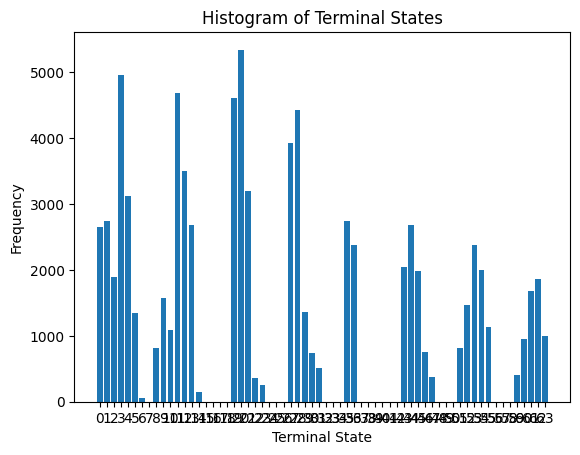

In [23]:
# prompt: make a historgram showing outcomes of episodes

import matplotlib.pyplot as plt

# Assuming 'terminal_states' is the list of terminal states from the previous code
plt.hist(terminal_states, bins=range(n_states + 1), align='left', rwidth=0.8)
plt.xlabel("Terminal State")
plt.ylabel("Frequency")
plt.title("Histogram of Terminal States")
plt.xticks(range(n_states)) # Set x-axis ticks to integers representing states
plt.show()


In [22]:
env

<TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>>

In [26]:
print(env.unwrapped.desc)  # Print environment map to verify holes



[[b'S' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'H' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'H' b'F' b'F' b'F' b'F' b'F']
 [b'H' b'H' b'H' b'F' b'F' b'H' b'H' b'H']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'H' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'H' b'F' b'F' b'F' b'F' b'G']]


In [33]:
hole_states = set(np.where(env.desc == b"H")[0])  # Identify hole positions


In [34]:
hole_states

{2, 3, 4, 6, 7}